## Ocean Biogeochemical Dynamics Lab, Spring 2021
Introduction to Python and Jupyter Notebooks by Nancy Williams

This code covers importing, cleaning, and plotting data from a single SOCCOM float in the Southern Ocean. 

SOCCOM website: https://soccom.princeton.edu/

# Import toolboxes
Always start by importing the tools you will need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots, too
import cartopy.crs as ccrs
import cartopy.feature
import seawater
import xarray as xr
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 18
#plt.rcParams['lines.linewidth'] = 3
# this forces matplotlib to print figures out here when you make plots
from IPython.display import Image

# Press Shift + Enter to "run" this cell and move on to the next one 

In [2]:
Image(url='https://www3.mbari.org/soccom/images/SOOCNMAP.jpg', width=800)

In [3]:
# This is how you make a comment!
# Always annotate your code so you know what you did and why
# I promise you won't remember the details when it comes time to write up the results

# Ideally, you are also using some kind of version control like github
# version control allows you to track changes in your code, revert back if you need to,
# or even branch a piece of code off into two independent versions.
# Also great for collaborative projects

Start a new "cell" when you transition to a new step in your code. This allows you to run your code in chunks and better troubleshoot where issues might be. Press Option + Enter to add run and an empty cell below this one
# Download the SOCCOM float data snapshot
This code imports a SOCCOM biogeochemical Argo Float "snapshot" dataset from December 2020 for one float. A snapshot means that the data have been archived with a "doi" or digital object identifier. It is frozen in time and is citable, which is important for reproducibiity. When using this dataset for science and publication, it will also be important to document the steps you take when cleaning, reformatting, renaming, changing units, and any calculations you do. 

The entire .zip file with all floats can be downloaded here: 
https://library.ucsd.edu/dc/object/bb94601812 as the "LIAR High resolution ODV format"

The SOCCOM floats measure pH and other carbonate system parameters are estimated by combining float-measured pH with an estimate for alkalinity based on empirical relationships and shipboard bottle samples. There are several options for this alkalinity product (LIAR, MLR, and CANYON). Here we will use LIAR (Locally Interpolated Alkalinity Regression of Carter et al. (2018) http://doi.wiley.com/10.1002/lom3.10232). 

The files are also available in low resolution and high resolution. The core physical sensors (temperature, salinity, and pressure) measure at a higher depth resolution than the BGC sensors. If you choose low-resolution you lose this high resolution physical data. If you choose high resolution you get the full resolution of physical data and the depths which have no BGC data are empty.

There are both raw and QC files available. The QC (quality control) methods are quite mature at this point and so it is best to use the QC'ed data. If you are working on a project that focuses on sensor QC or you wish to do your own QC, then you may need to download the raw dataset.

It is easiest to place the file in the same directory where this code lives. I've already downloaded and unzipped that folder and it's called `SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt`.  What's inside?


# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called `flt`. Float 9254 is a good example float, but you can pick any float from the snapshot. To pick another float you can go to the SOCCOM web page sensor status table http://soccom.ucsd.edu/floats/SOCCOM_sensor_stats.html and choose a float with lots of good data (i.e., more in the "#g" column than the "#b" columns for variables you're interested in analyzing. You can sort the columns on that webpage by clicking on the column header by which you wish to sort.

In [4]:
# Pick a float
floatnum='9254' 
# you can change this number to look at a different float and it will update throughout the file
# A value in '' is a string type, not a number to be used in calculations.
# A string can also contain letters and symbols

floatpath='SOCCOM_HiResQC_LIAR_22Dec2020_odvtxt/' # This is the folder where all the float data live
floatsuffix='SOOCN_HRQC.TXT' # all of the Southern Ocean floats have the same suffix
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False) # concatenates or links together strings
# There are a bunch of other input options for this read_csv function, and you can see them by
# pressing "tab" inside the parenthesis following the function name.

b'Skipping line 24: expected 1 fields, saw 3\nSkipping line 27: expected 1 fields, saw 3\nSkipping line 29: expected 1 fields, saw 2\nSkipping line 30: expected 1 fields, saw 6\nSkipping line 31: expected 1 fields, saw 2\nSkipping line 32: expected 1 fields, saw 2\nSkipping line 36: expected 1 fields, saw 3\nSkipping line 38: expected 1 fields, saw 3\nSkipping line 40: expected 1 fields, saw 3\nSkipping line 41: expected 1 fields, saw 2\nSkipping line 42: expected 1 fields, saw 3\nSkipping line 44: expected 1 fields, saw 2\nSkipping line 46: expected 1 fields, saw 2\nSkipping line 48: expected 1 fields, saw 2\nSkipping line 49: expected 1 fields, saw 5\nSkipping line 53: expected 1 fields, saw 3\nSkipping line 55: expected 1 fields, saw 4\nSkipping line 59: expected 1 fields, saw 3\nSkipping line 64: expected 1 fields, saw 4\nSkipping line 82: expected 1 fields, saw 4\n'


In [5]:
# Python doesn't typically spit out the results unless you ask for them.
# This is how you look at just the "head" the flt dataframe
flt.head()

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 19:30
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904395
4,//Univ. of Washington ID: 9254


In [6]:
# This is how you look at the whole flt dataframe
# It's a big dataframe so this will show you just the head and the tail
flt

,//0
0,//<Encoding>UTF-8</Encoding>
1,//File updated on 12/21/2020 19:30
2,//!! ADJUSTED DATA FILE !!
3,//WMO ID: 5904395
4,//Univ. of Washington ID: 9254
...,...
93715,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93716,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93717,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...
93718,5904395\t172\tC\t10/22/2017\t16:49\t202.167\t-...


## Comment lines in data files
Clearly something is wrong. We didn't get any meaningful data! Why? Because those are comment lines in the top of the data file.  Let's try telling read_cvs what a comment looks like. We see from the file that the comment lines start with '//'.

In [7]:
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False, comment='/')
# There are a bunch of other input options for this function, and you can see them by
# typing a comma and then pressing "tab" from inside the function parentheses
# Run this new read_csv function and look at the header of the new flt dataframe
# By running this code you overwrite your last flt dataframe
flt.head()

,Cruise\tStation\tType\tmon
0,5904395\t1\tC\t04
1,5904395\t1\tC\t04
2,5904395\t1\tC\t04
3,5904395\t1\tC\t04
4,5904395\t1\tC\t04


## Delimiters
We are getting warmer, we now see a more meaningful header and some data, but what are those "\t"s? Those are tab delimiters or separators. "CSV" stands for Comma Separated Values and "TSV" stands for Tab Separated Values. The files typically look identical and the delimiters are often invisible when viewed from excel or a text editor (but you should never use excel to edit text files! Excel can change the format when you save and mess up your code). 

So now we need to tell read_csv what the delimiter is:

In [8]:
flt=pd.read_csv(floatpath+floatnum+floatsuffix, error_bad_lines=False, 
                comment='/', delimiter='\t')
# If your line of code is getting long and you're inside a parentheses, simply press 
# enter in the code to continue your code onto a new line.
# Look at the head
flt.head()

,Cruise,Station,Type,mon
0,5904395,1,C,4
1,5904395,1,C,4
2,5904395,1,C,4
3,5904395,1,C,4
4,5904395,1,C,4


In [9]:
# That looks better, now let's look at the info for the file to see more:
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Cruise   93657 non-null  int64 
 1   Station  93657 non-null  int64 
 2   Type     93657 non-null  object
 3   mon      93657 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.9+ MB


We are getting many rows of data, but only four columns. Why? 

Because the "comment" character used in these float data files is two forward slashes "//". Unfortunately, Pandas read_csv can only handle one character in the comment field. Because we entered '/' on any line as the comment character, we also lose everything after any '/'. In this case, we lose everything after "mon" in the header row and in all data rows. When creating a data file like this .txt file, you should never use your delimiter/separator character anywhere else in your data file. To work around this, we will first open the file and replace all instances of '//' with '#'. (I checked to make sure "#" isn't used in the actual data anywhere)

In [10]:
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

## NaN values
NaN (Not a Number) values are used to fill in data files where there is either no data or there is bad data. Instead of NaN, SOCCOM used an absurdly small number as their fill value, a number which is not zero but is so small that you would never get the value from a sensor. You could also use an absurdly large number. We want to replace that fill value with NaN, which python is better equipped to handle. If you don't do this, you can mess up your data because you've got a ton of near-zero values in your calculations.

In [11]:
flt=pd.read_csv('fltrem.txt',delimiter='\t',comment='#',na_values=-1E10)
# Now I've also added a term to tell read_csv what the "not a number" value is in the file

In [12]:
#take a look at the info for the flt dataframe you have made
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cruise               93657 non-null  int64  
 1   Station              93657 non-null  int64  
 2   Type                 93657 non-null  object 
 3   mon/day/yr           93657 non-null  object 
 4   hh:mm                93657 non-null  object 
 5   Lon [°E]             93657 non-null  float64
 6   Lat [°N]             93657 non-null  float64
 7   QF                   93657 non-null  int64  
 8   Pressure[dbar]       93485 non-null  float64
 9   QF.1                 93485 non-null  float64
 10  Temperature[°C]      93485 non-null  float64
 11  QF.2                 93485 non-null  float64
 12  Salinity[pss]        93485 non-null  float64
 13  QF.3                 93485 non-null  float64
 14  Sigma_theta[kg/m^3]  93485 non-null  float64
 15  QF.4                 93485 non-null 

In [13]:
# look at the head of the data frame
flt.head()

,Cruise,Station,Type,mon/day/yr,hh:mm,Lon [°E],Lat [°N],QF,Pressure[dbar],QF.1,...,pHinsitu[Total],QF.14,pH25C[Total],QF.15,TALK_LIAR[µmol/kg],QF.16,DIC_LIAR[µmol/kg],QF.17,pCO2_LIAR[µatm],QF.18
0,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1598.67,0.0,...,7.8275,0.0,7.5726,0.0,2339.0,0.0,2252.0,0.0,564.3,0.0
1,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1498.62,0.0,...,7.8265,0.0,7.5703,0.0,2328.0,0.0,2242.0,0.0,570.1,0.0
2,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1399.08,0.0,...,7.8334,0.0,7.5757,0.0,2313.0,0.0,2226.0,0.0,564.0,0.0
3,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1298.90,0.0,...,24.6429,8.0,NaN,1.0,2303.0,0.0,NaN,1.0,NaN,1.0
4,5904395,1,C,04/21/2014,18:36,209.981,-39.698,0,1199.63,0.0,...,7.8602,0.0,7.6039,0.0,2298.0,0.0,2201.0,0.0,539.0,0.0


## Dates
Notice that the date format is in a text string, and we will want it in a number or "datetime" format. We can use a pandas function to_datetime to do this conversion and the new variable 'date' is appended to the end of the pandas dataframe.

In [14]:
flt['date']=pd.to_datetime(flt['mon/day/yr']+' '+ flt['hh:mm'])
flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cruise               93657 non-null  int64         
 1   Station              93657 non-null  int64         
 2   Type                 93657 non-null  object        
 3   mon/day/yr           93657 non-null  object        
 4   hh:mm                93657 non-null  object        
 5   Lon [°E]             93657 non-null  float64       
 6   Lat [°N]             93657 non-null  float64       
 7   QF                   93657 non-null  int64         
 8   Pressure[dbar]       93485 non-null  float64       
 9   QF.1                 93485 non-null  float64       
 10  Temperature[°C]      93485 non-null  float64       
 11  QF.2                 93485 non-null  float64       
 12  Salinity[pss]        93485 non-null  float64       
 13  QF.3                 93485 non-

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

### Where is your float in relation to the fronts of the ACC?
The following code imports the longitudes and latitudes of the five fronts. There are some '%' values in the files which creates breaks in the fronts. If we did not keep these breaks, the fronts would plot across continents.

In [15]:
stf=pd.read_csv('fronts/stf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saf=pd.read_csv('fronts/saf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
pf=pd.read_csv('fronts/pf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
saccf=pd.read_csv('fronts/saccf.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
sbdy=pd.read_csv('fronts/sbdy.txt',header=None,sep='\s+',na_values='%', names=['lon','lat'])
# Check one of the fronts and make sure it looks as you thinkg it should
pf

,lon,lat
0,NaN,NaN
1,-179.97,-61.71
2,-179.21,-61.54
3,-178.66,-61.42
4,-178.18,-61.31
...,...,...
965,177.47,-62.40
966,177.90,-62.31
967,178.45,-62.16
968,179.16,-61.95


### Cartopy
The following is an example of a South Polar Stereographic map using Cartopy https://scitools.org.uk/cartopy/docs/latest/#. Polar stereographic maps are always a bit more complicated because you have to translate your coordinates to polar coordinates.

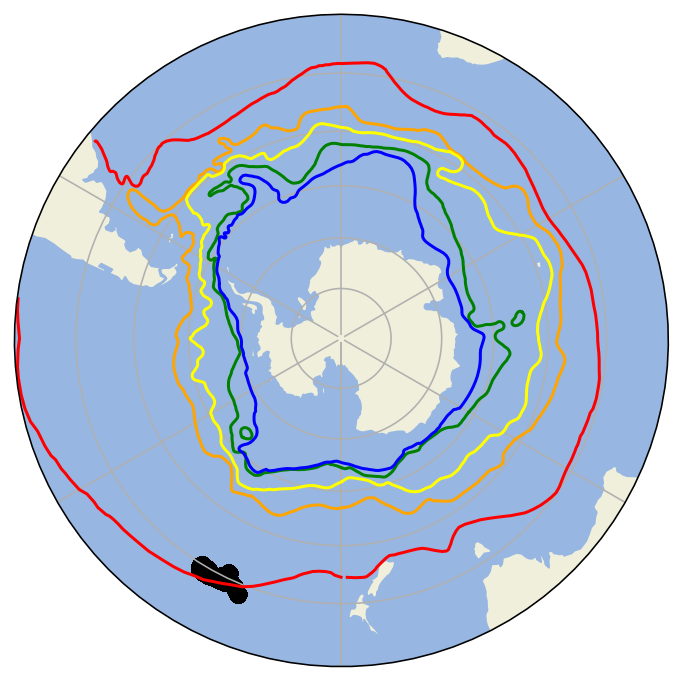

In [16]:
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30],ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
plt.plot(stf['lon'],stf['lat'],color='Red',transform=ccrs.PlateCarree())
plt.plot(saf['lon'],saf['lat'],color='Orange',transform=ccrs.PlateCarree())
plt.plot(pf['lon'],pf['lat'],color='Yellow',transform=ccrs.PlateCarree())
plt.plot(saccf['lon'],saccf['lat'],color='Green',transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'],sbdy['lat'],color='Blue',transform=ccrs.PlateCarree())

plt.scatter(flt['Lon [°E]'],flt['Lat [°N]'],color='Black',transform=ccrs.PlateCarree())
plt.savefig('SPstereo.pdf')
plt.savefig('SPstereo.png') # Changing the suffix will change the format
plt.show()

# Plotting profiles

Now, let's make a quick plot of temperature versus pressure. This method is quick and dirty but doesn't give us much control over the figure

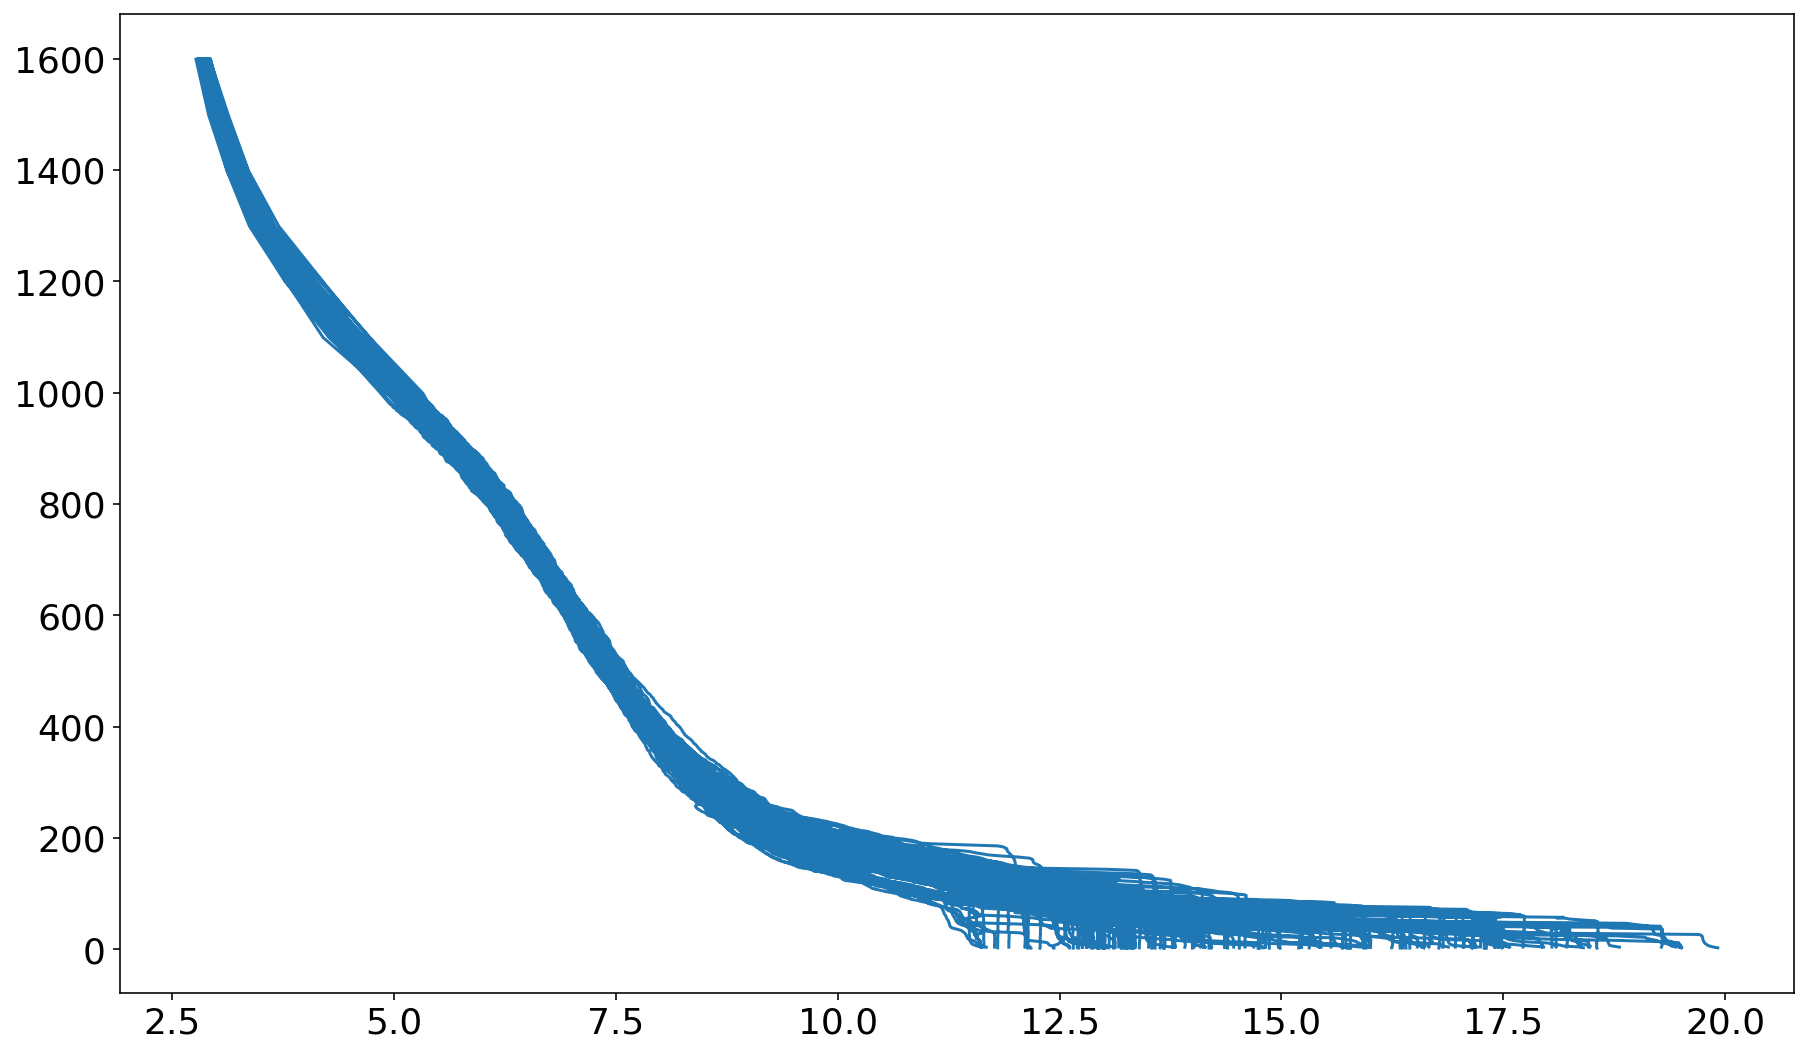

In [17]:
plt.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])

Text(0, 0.5, 'Pressure [dbar]')

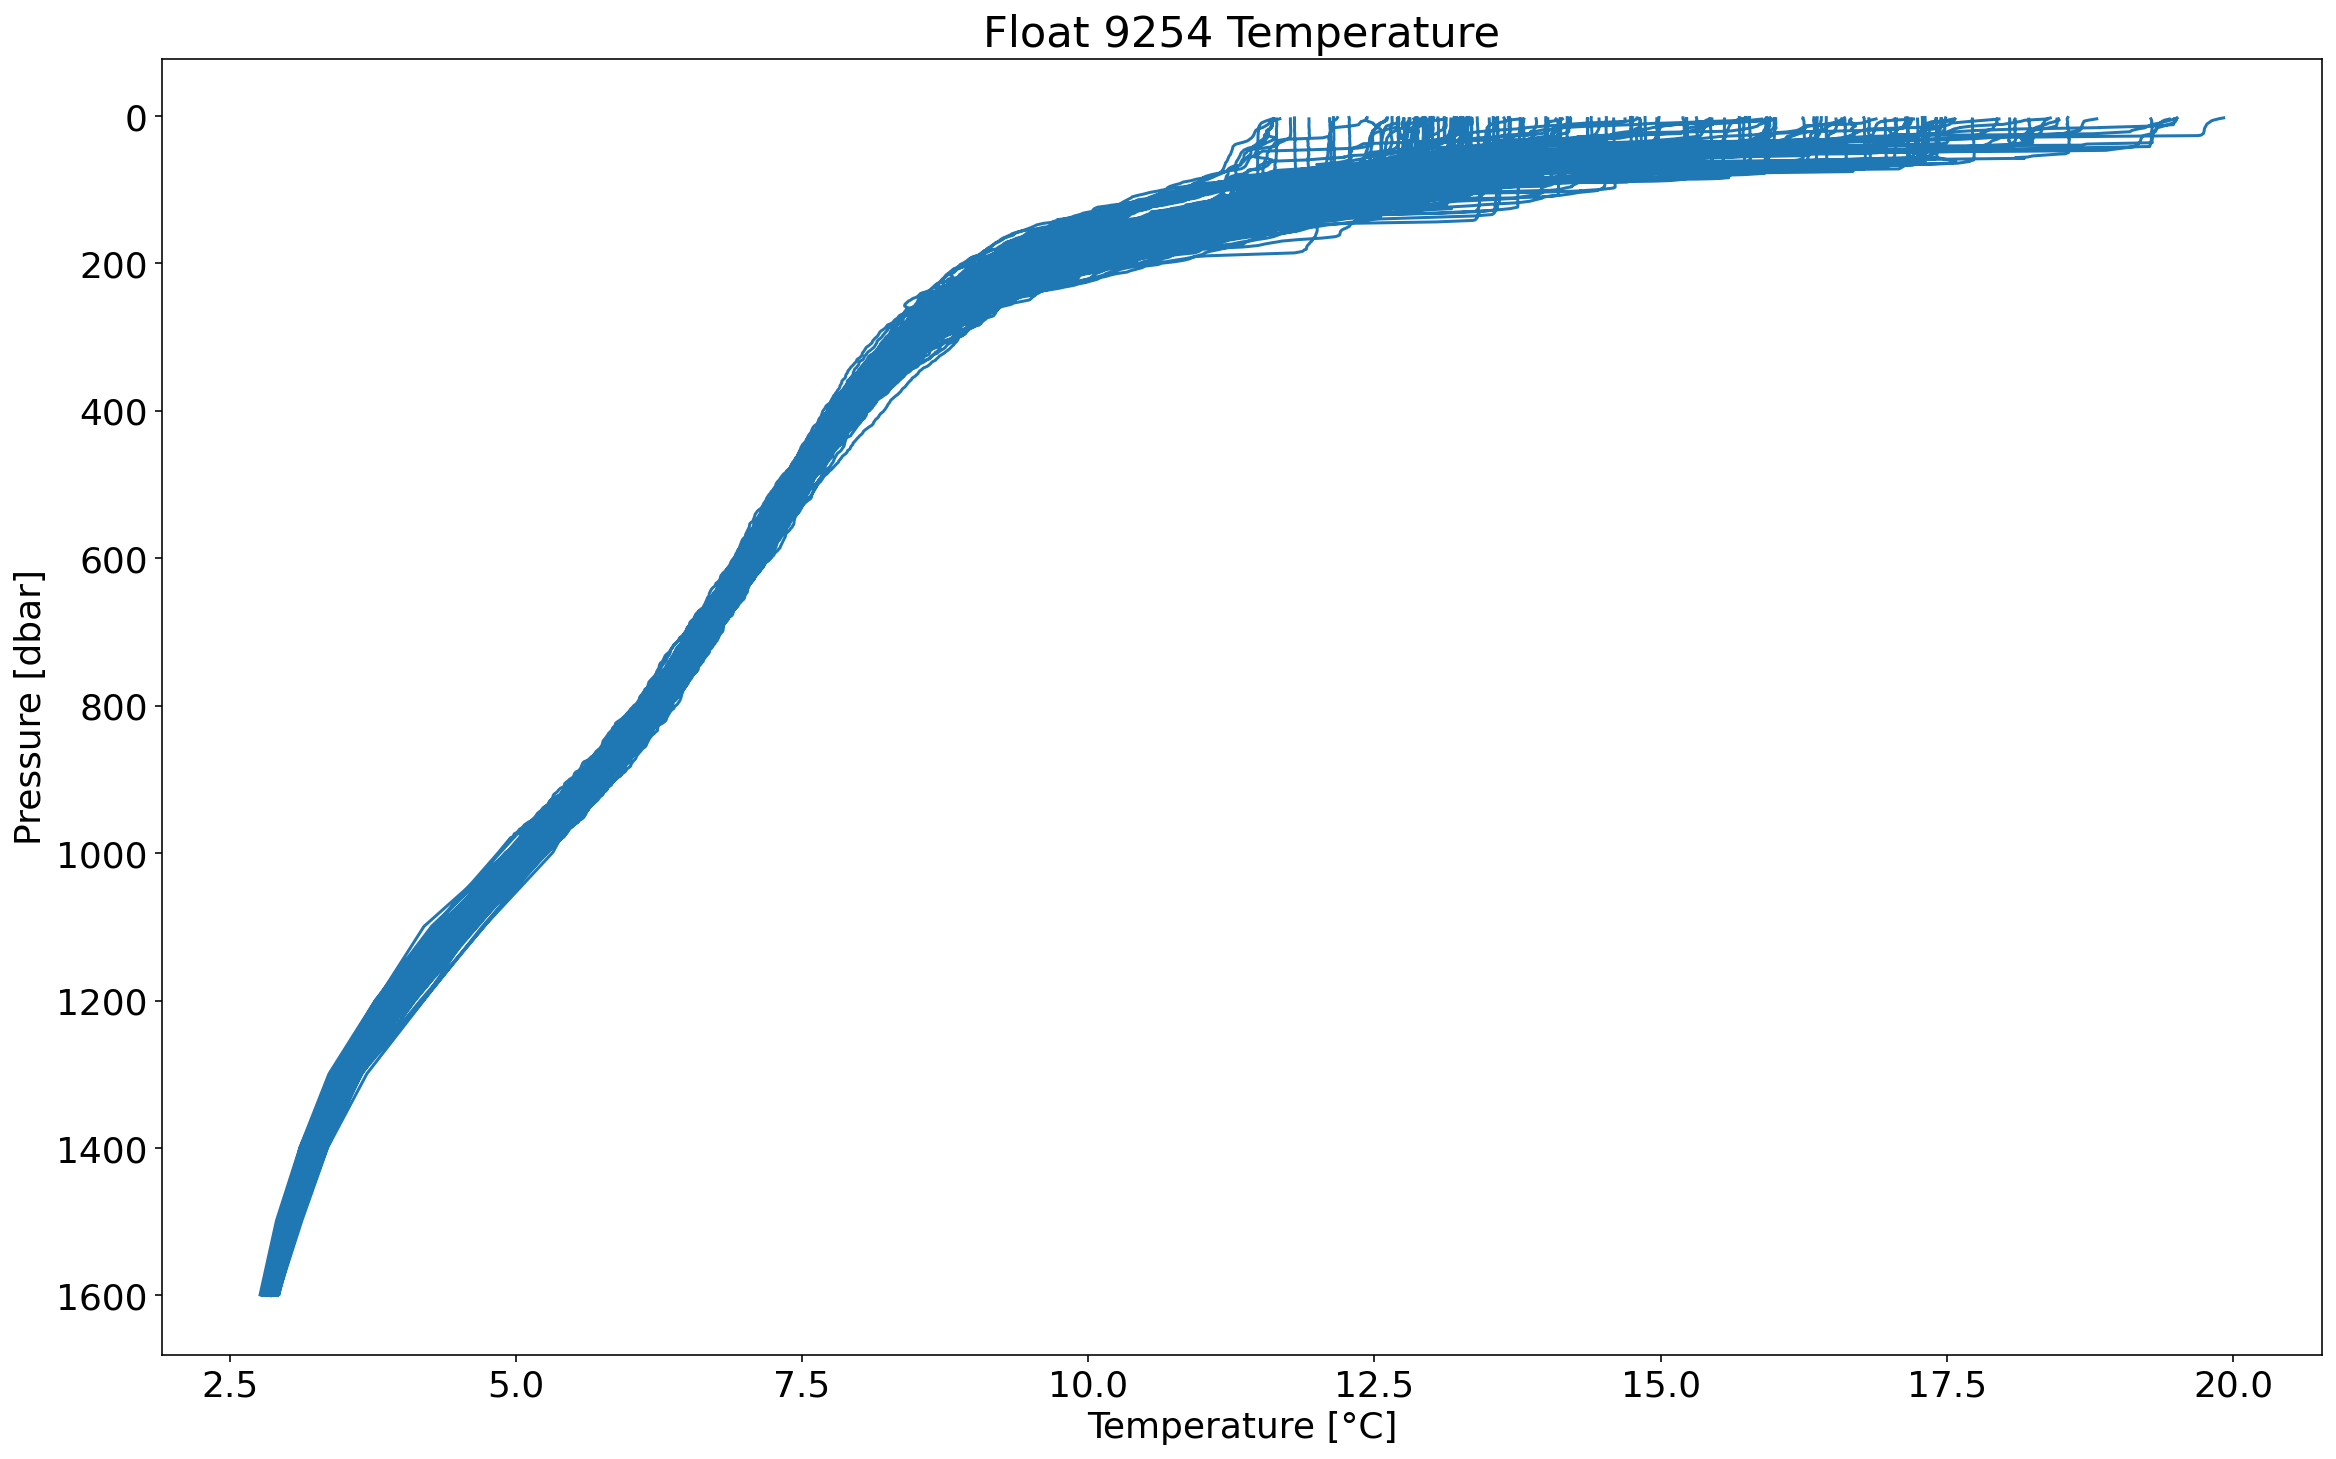

In [18]:
# Something funny? 
# We want to invert the axis and add some labels

# Now we will use the object-oriented programming to have more control over the plot
fig = plt.figure()
# this allows you to create multiple axes
axes1= fig.add_axes([0, 0, 1, 1])
axes1.plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
axes1.set_title('Float '+floatnum+' Temperature')
axes1.invert_yaxis()
axes1.set_xlabel('Temperature [°C]')
axes1.set_ylabel('Pressure [dbar]')
# if you wanted to add a subplot you would add it like this
#axes2= fig.add_axes([.7, .7, .2, .2])

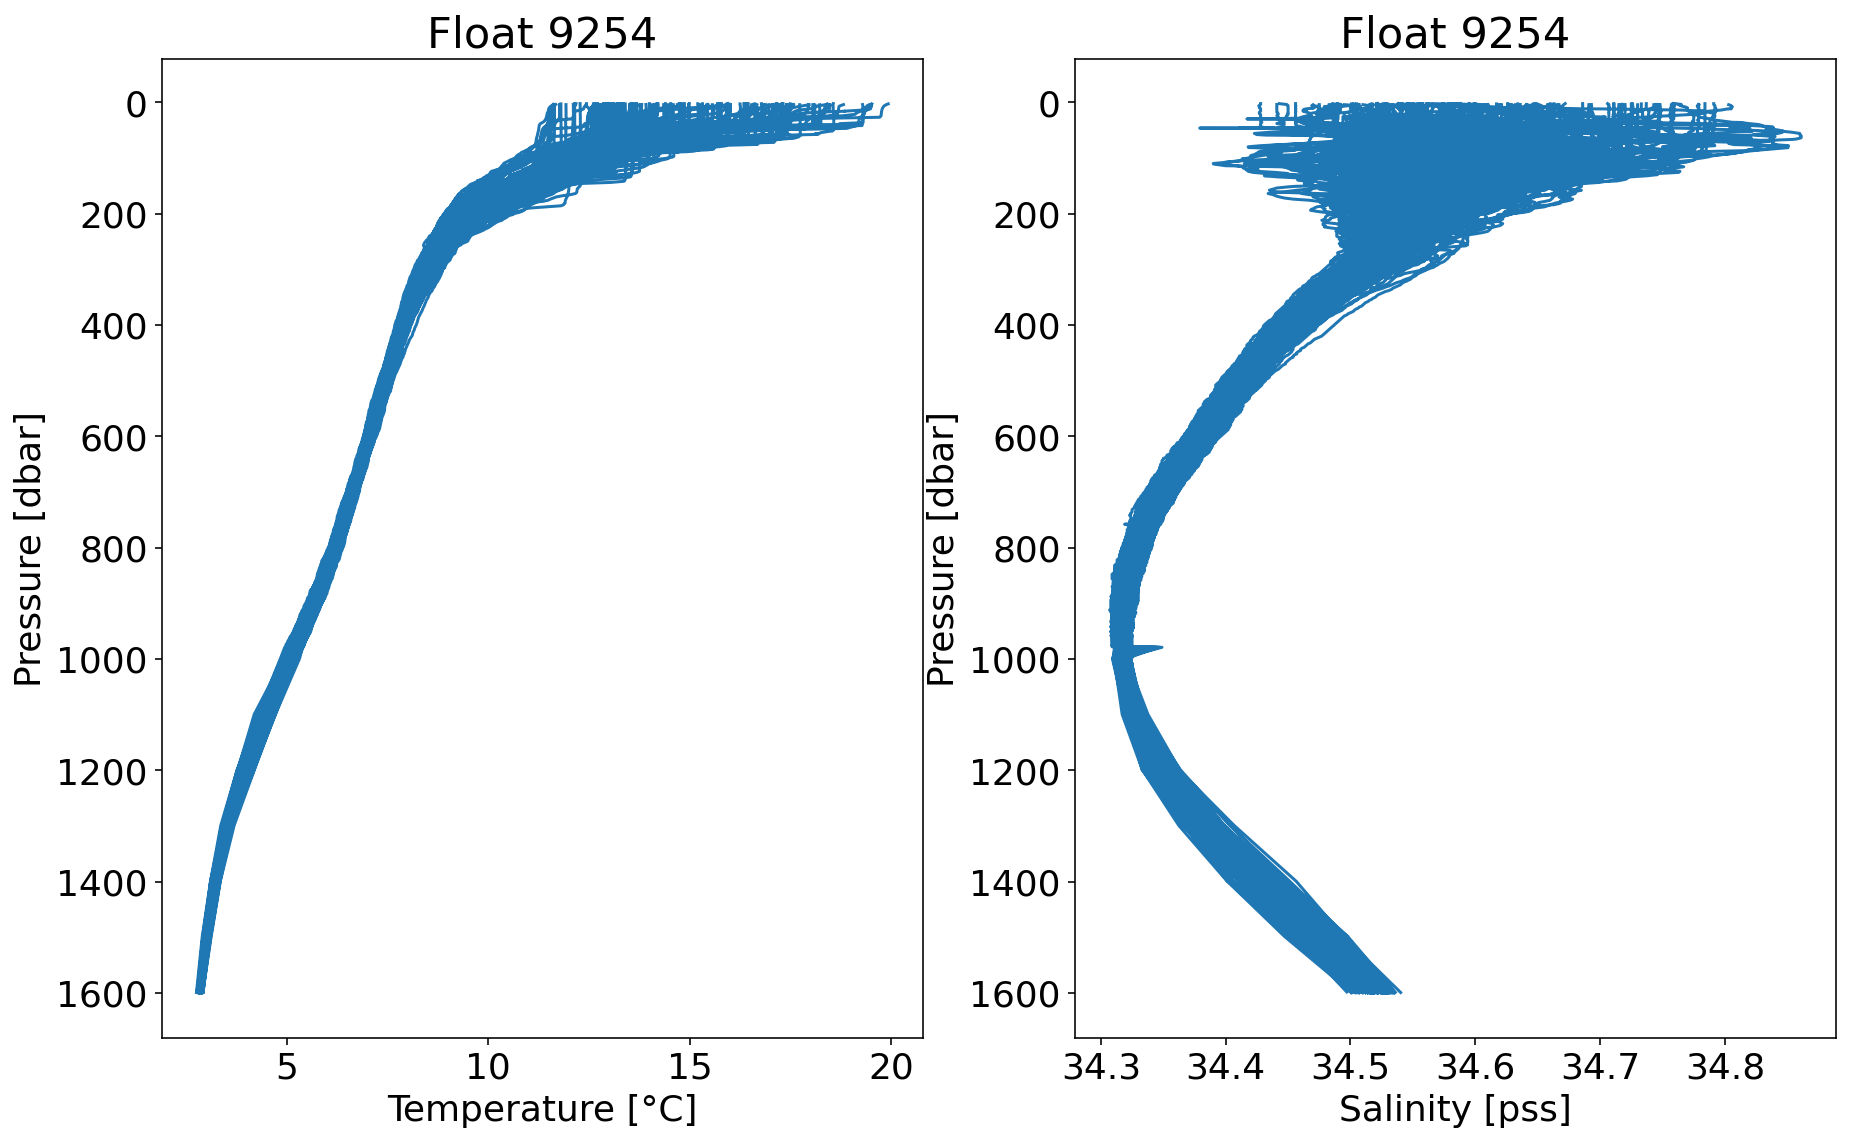

In [19]:
# Can also use subplots function
fig,axes = plt.subplots(nrows = 1, ncols = 2)
# if you have many subplots and some overlap, use tight_layout, or you can leave it 
# at the end of all of your plot statements
# Or you can add bbox_inches='tight' to your print statements

axes[0].plot(flt['Temperature[°C]'],flt['Pressure[dbar]'])
#axes[0].set_title('Temperature')
axes[0].invert_yaxis()
axes[0].set_ylabel('Pressure [dbar]')
axes[0].set_xlabel('Temperature [°C]')

axes[1].plot(flt['Salinity[pss]'],flt['Pressure[dbar]'])
#axes[1].set_title('Salinity')
axes[1].invert_yaxis()
axes[1].set_ylabel('Pressure [dbar]')
axes[1].set_xlabel('Salinity [pss]')
axes[0].set_title('Float '+floatnum)
axes[1].set_title('Float '+floatnum)
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig('F'+floatnum+'TS.png', dpi = 200, bbox_inches='tight')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93657 entries, 0 to 93656
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cruise               93657 non-null  int64         
 1   Station              93657 non-null  int64         
 2   Type                 93657 non-null  object        
 3   mon/day/yr           93657 non-null  object        
 4   hh:mm                93657 non-null  object        
 5   Lon [°E]             93657 non-null  float64       
 6   Lat [°N]             93657 non-null  float64       
 7   QF                   93657 non-null  int64         
 8   Pressure[dbar]       93485 non-null  float64       
 9   QF.1                 93485 non-null  float64       
 10  Temperature[°C]      93485 non-null  float64       
 11  QF.2                 93485 non-null  float64       
 12  Salinity[pss]        93485 non-null  float64       
 13  QF.3                 93485 non-

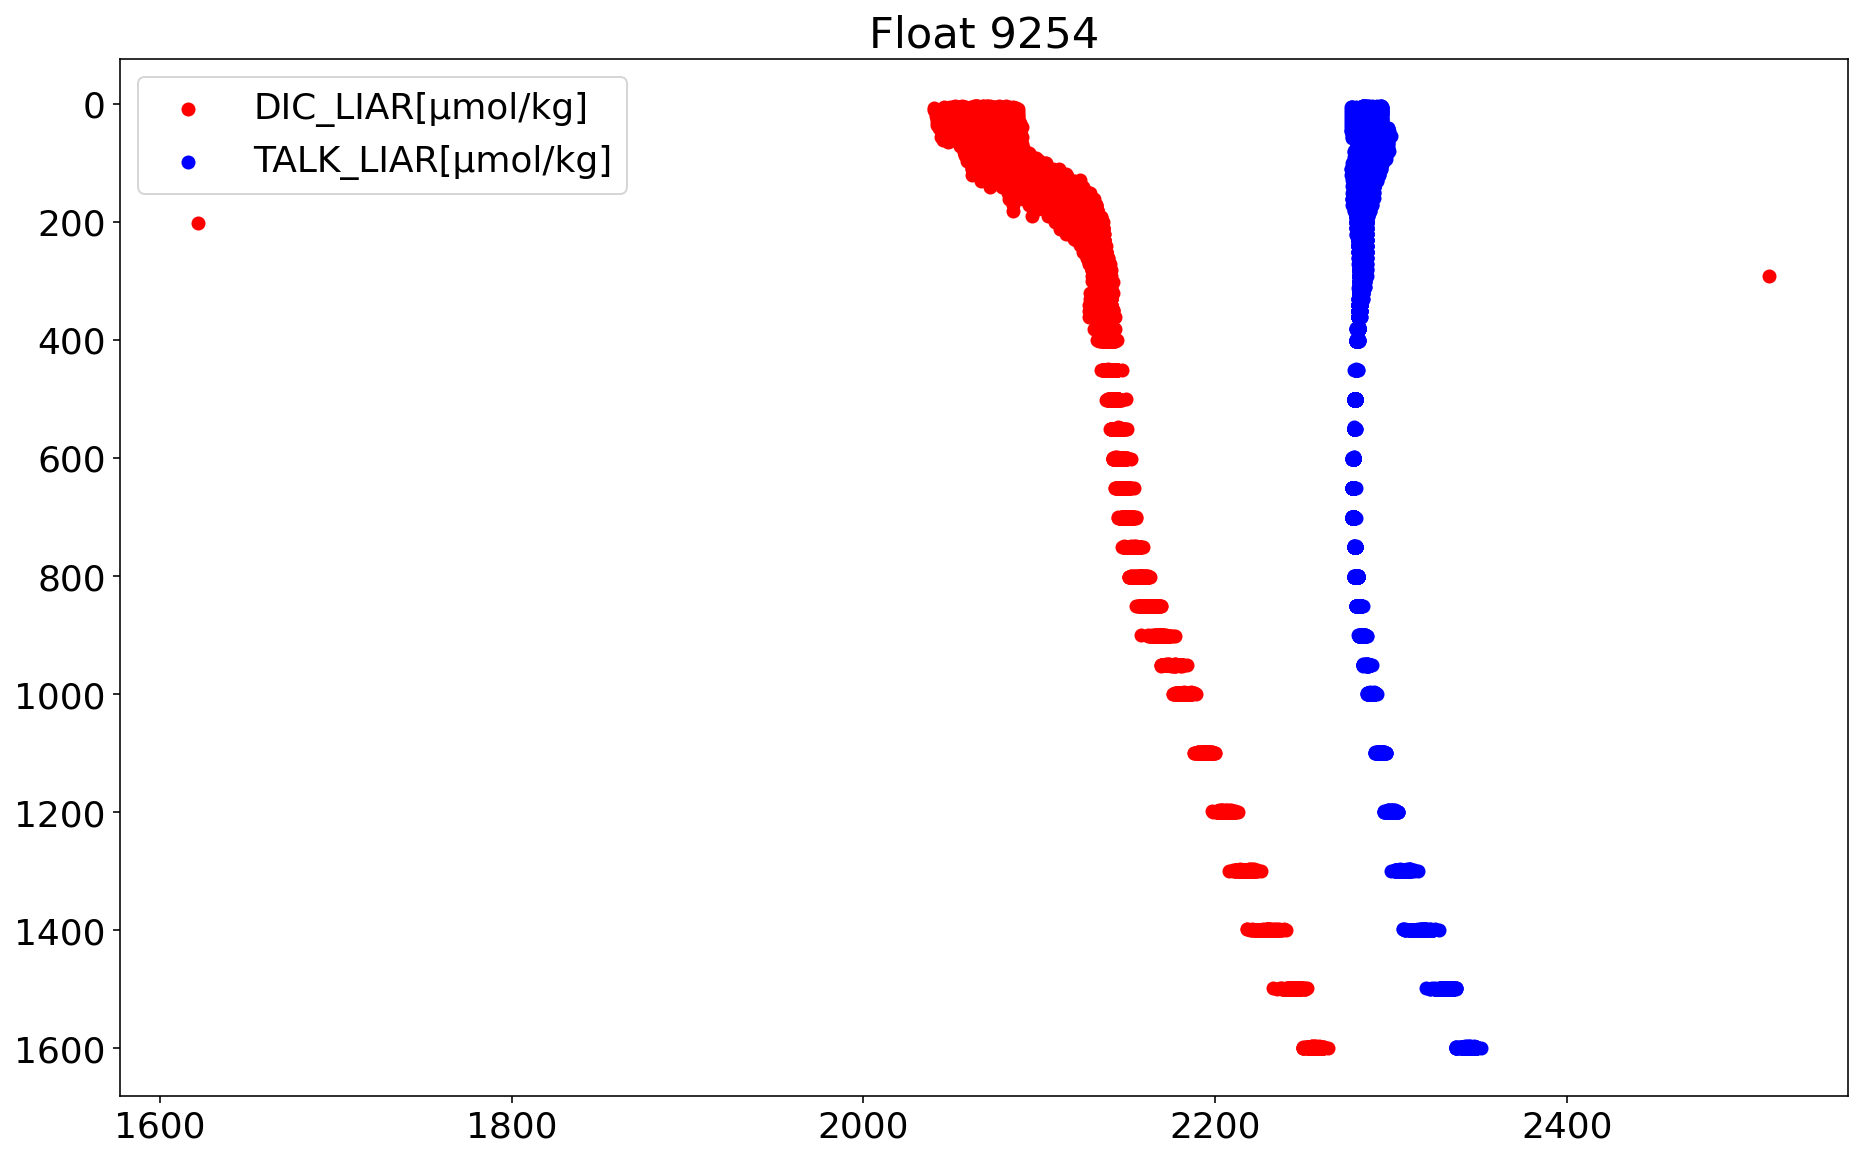

In [20]:
# Now let's plot multiple things on one axis
# Pick your variables:
var='DIC_LIAR[µmol/kg]'
var2='TALK_LIAR[µmol/kg]'
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt[var],flt['Pressure[dbar]'],label = var, color = 'red')
ax.scatter(flt[var2],flt['Pressure[dbar]'],label = var2, color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float '+floatnum)# Figure out how to have this be dynamic and change with the float number
ax.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+var2[0:3]+'.png', dpi = 200, bbox_inches='tight')
flt.info()

## Quality Flags
Clearly there are some bad data. Notice the QF or Quality Flag columns in the flt dataframe. These tell us which data are good, questionable, and bad. We only want to use good data. How can we tell which data are good?

Go back to the original text file and read the comments at the top of the file. Good data are flagged with zeros, and we should remove bad and questionable data which are flagged 4 and 3, respectively, and replace with NaN.

In [21]:
# Loop through all QF columns and apply them to the preceeding columns
from re import search
for column in range(len(flt.columns)):
    name=flt.columns[column]
    if search('QF',name): # if the column is a QF column, apply it to the preceeding column, otherwise go on to next column
        var=flt.columns[column-1]
        flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

Now make the same plot again and see if the weird data are gone:

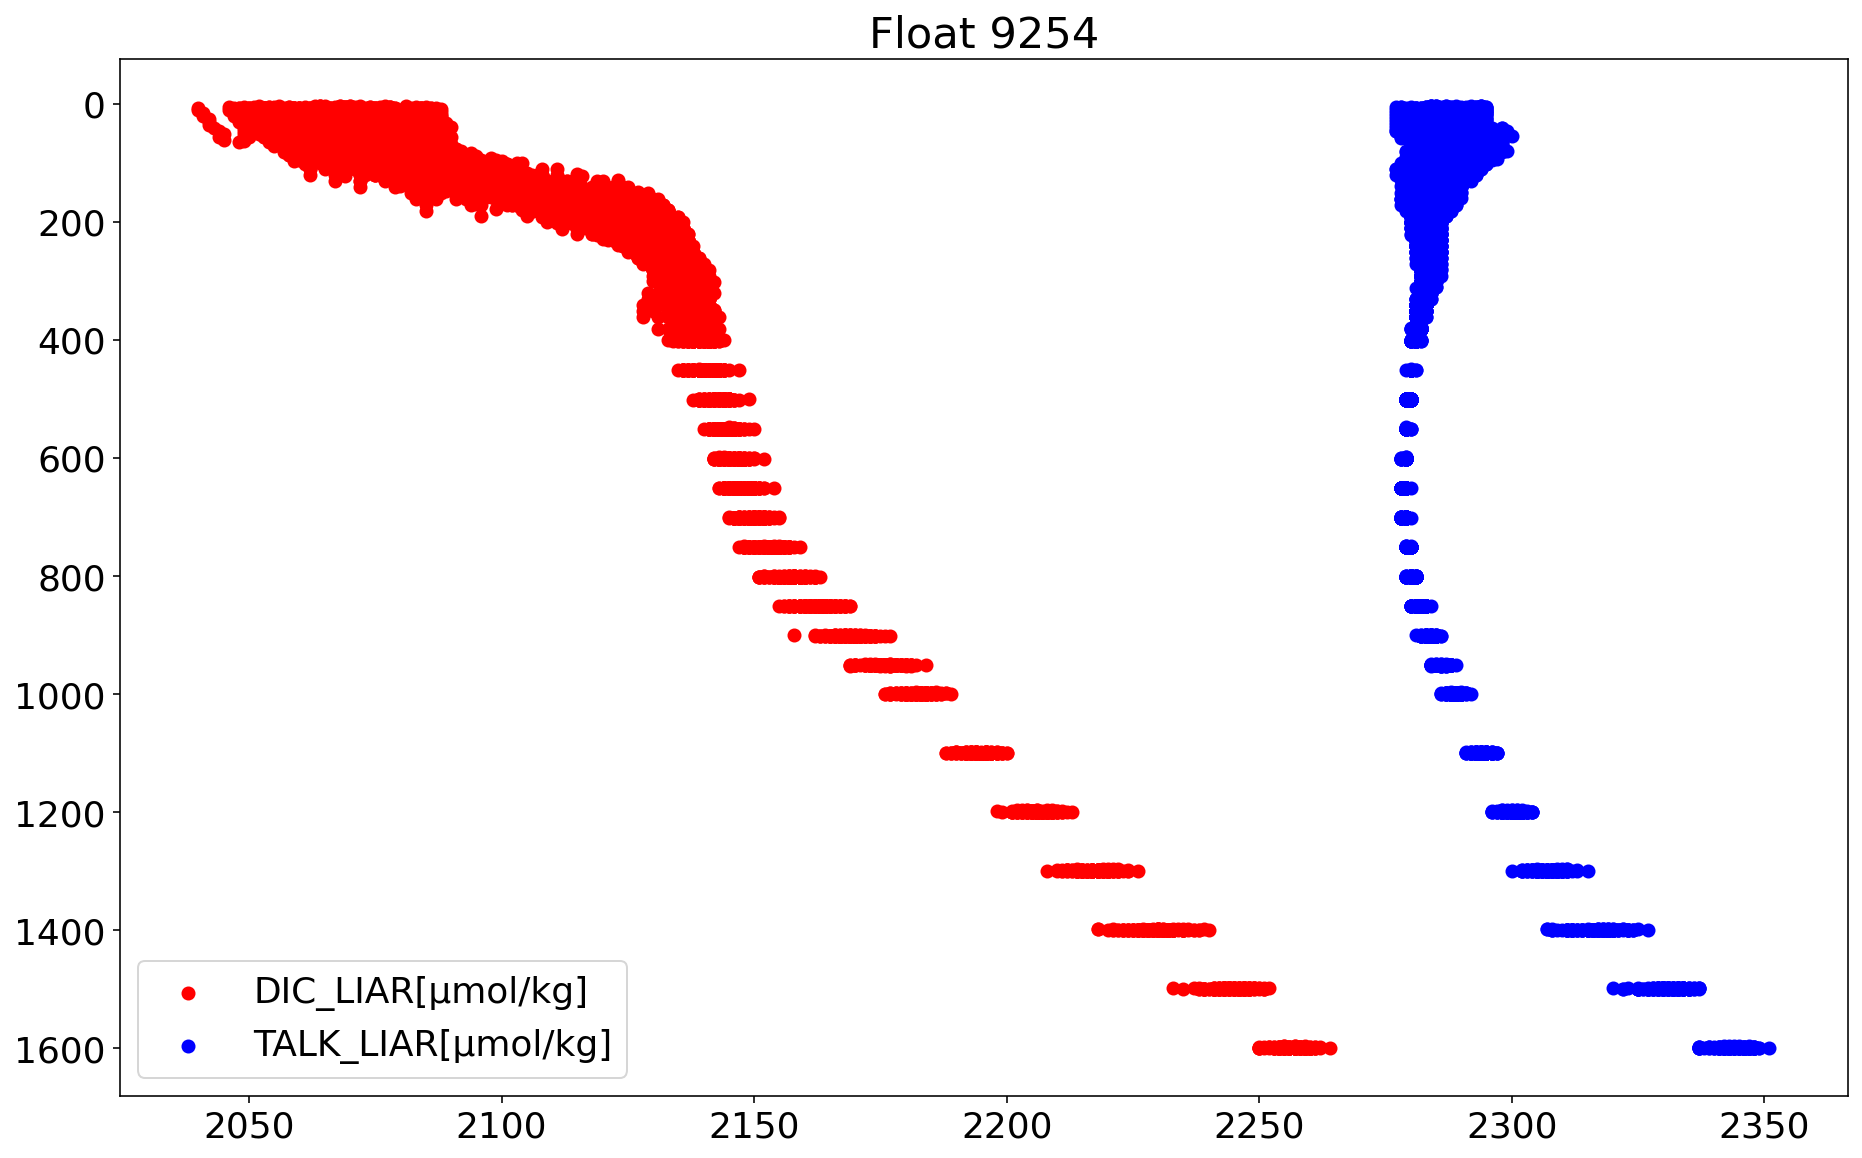

In [22]:
var='DIC_LIAR[µmol/kg]'
var2='TALK_LIAR[µmol/kg]'
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, .8, .8])
ax.scatter(flt[var],flt['Pressure[dbar]'],label = var, color = 'red')
ax.scatter(flt[var2],flt['Pressure[dbar]'],label = var2, color = 'blue') 
# for color you can also put in an RGB hex code
ax.legend(loc=0) # 0 is for the "best" location
ax.set_title('Float '+floatnum)# Figure out how to have this be dynamic and change with the float number
ax.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+var2[0:3]+'.png', dpi = 200)

Yes, they are!

Note: Careful, if you use "plot" we get a HUGE gap in the mid-water column because the BGC data are not high resolution. We need to use 'scatter' for the BGC data.

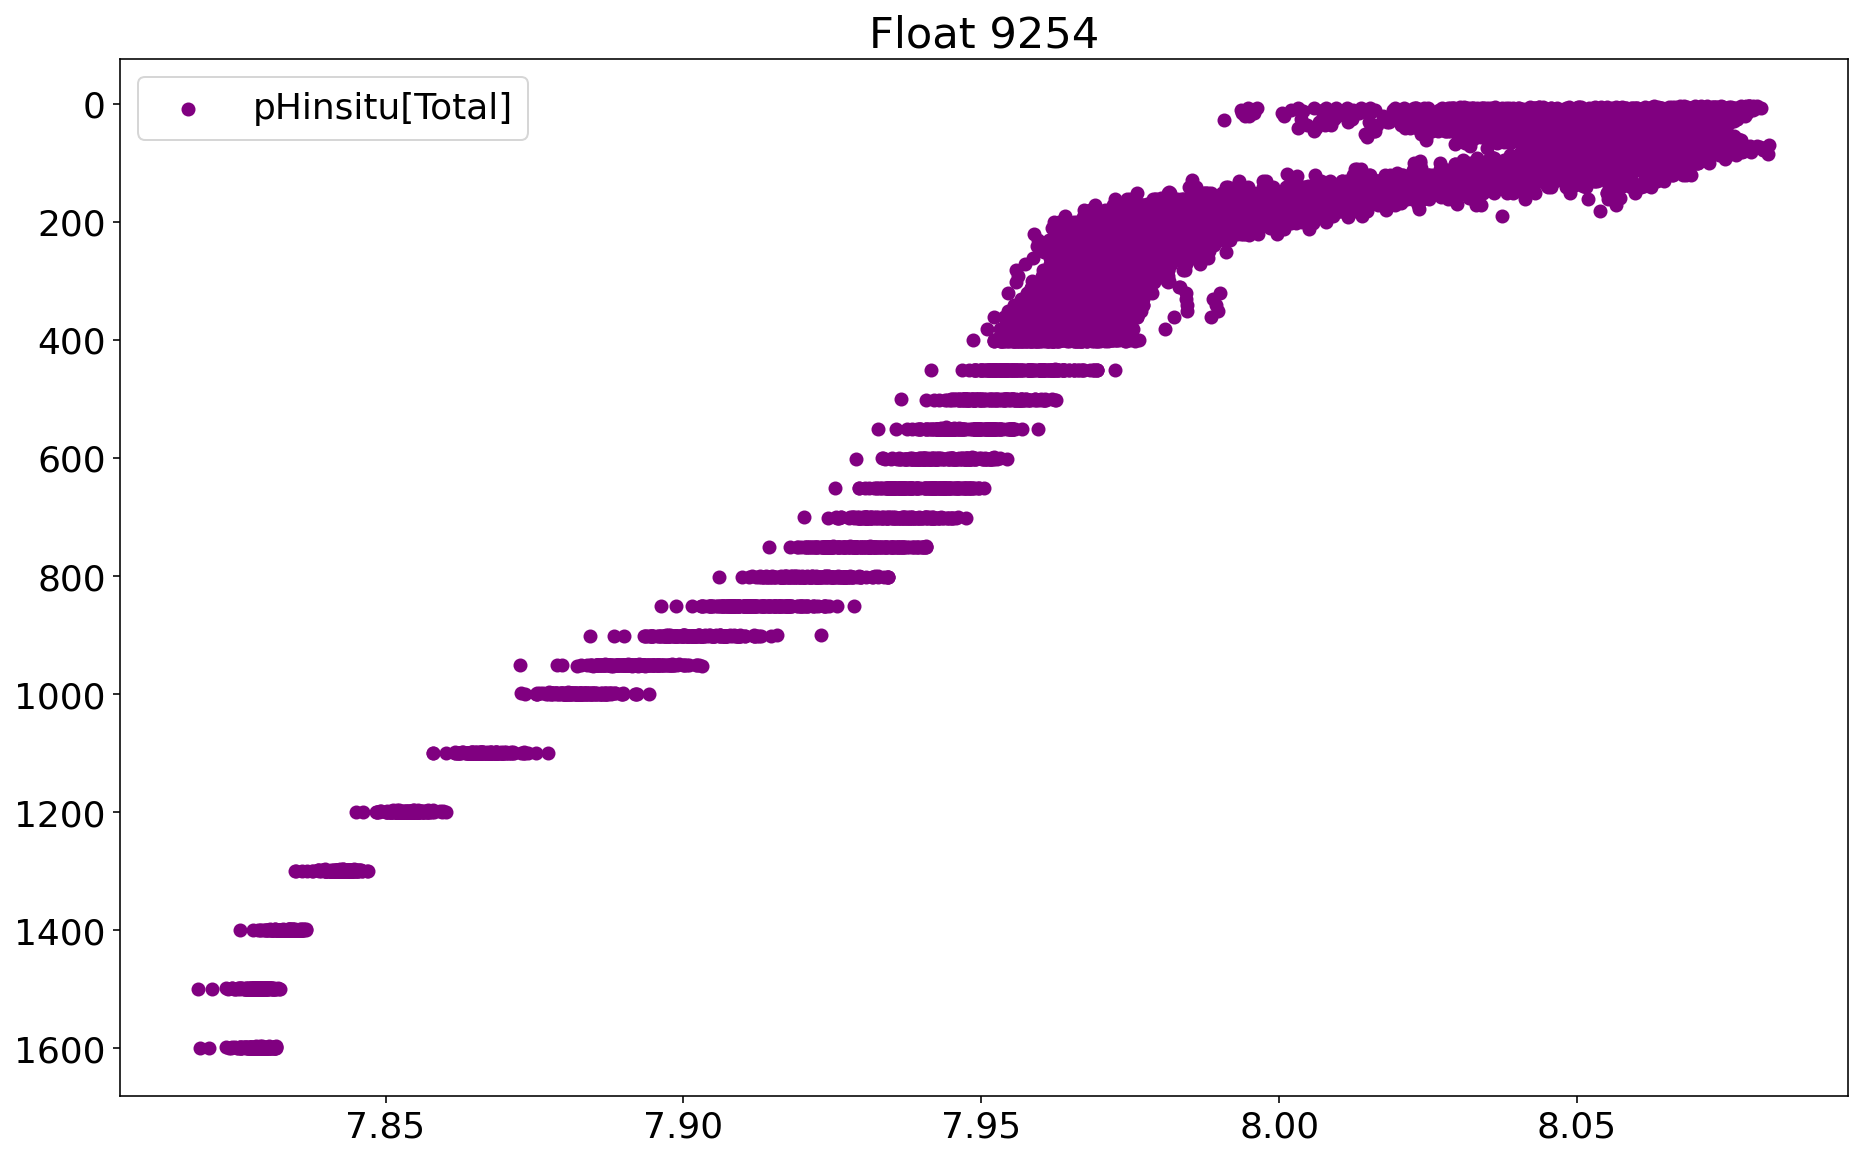

In [23]:
var='pHinsitu[Total]'
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='purple')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'.png', dpi = 200)

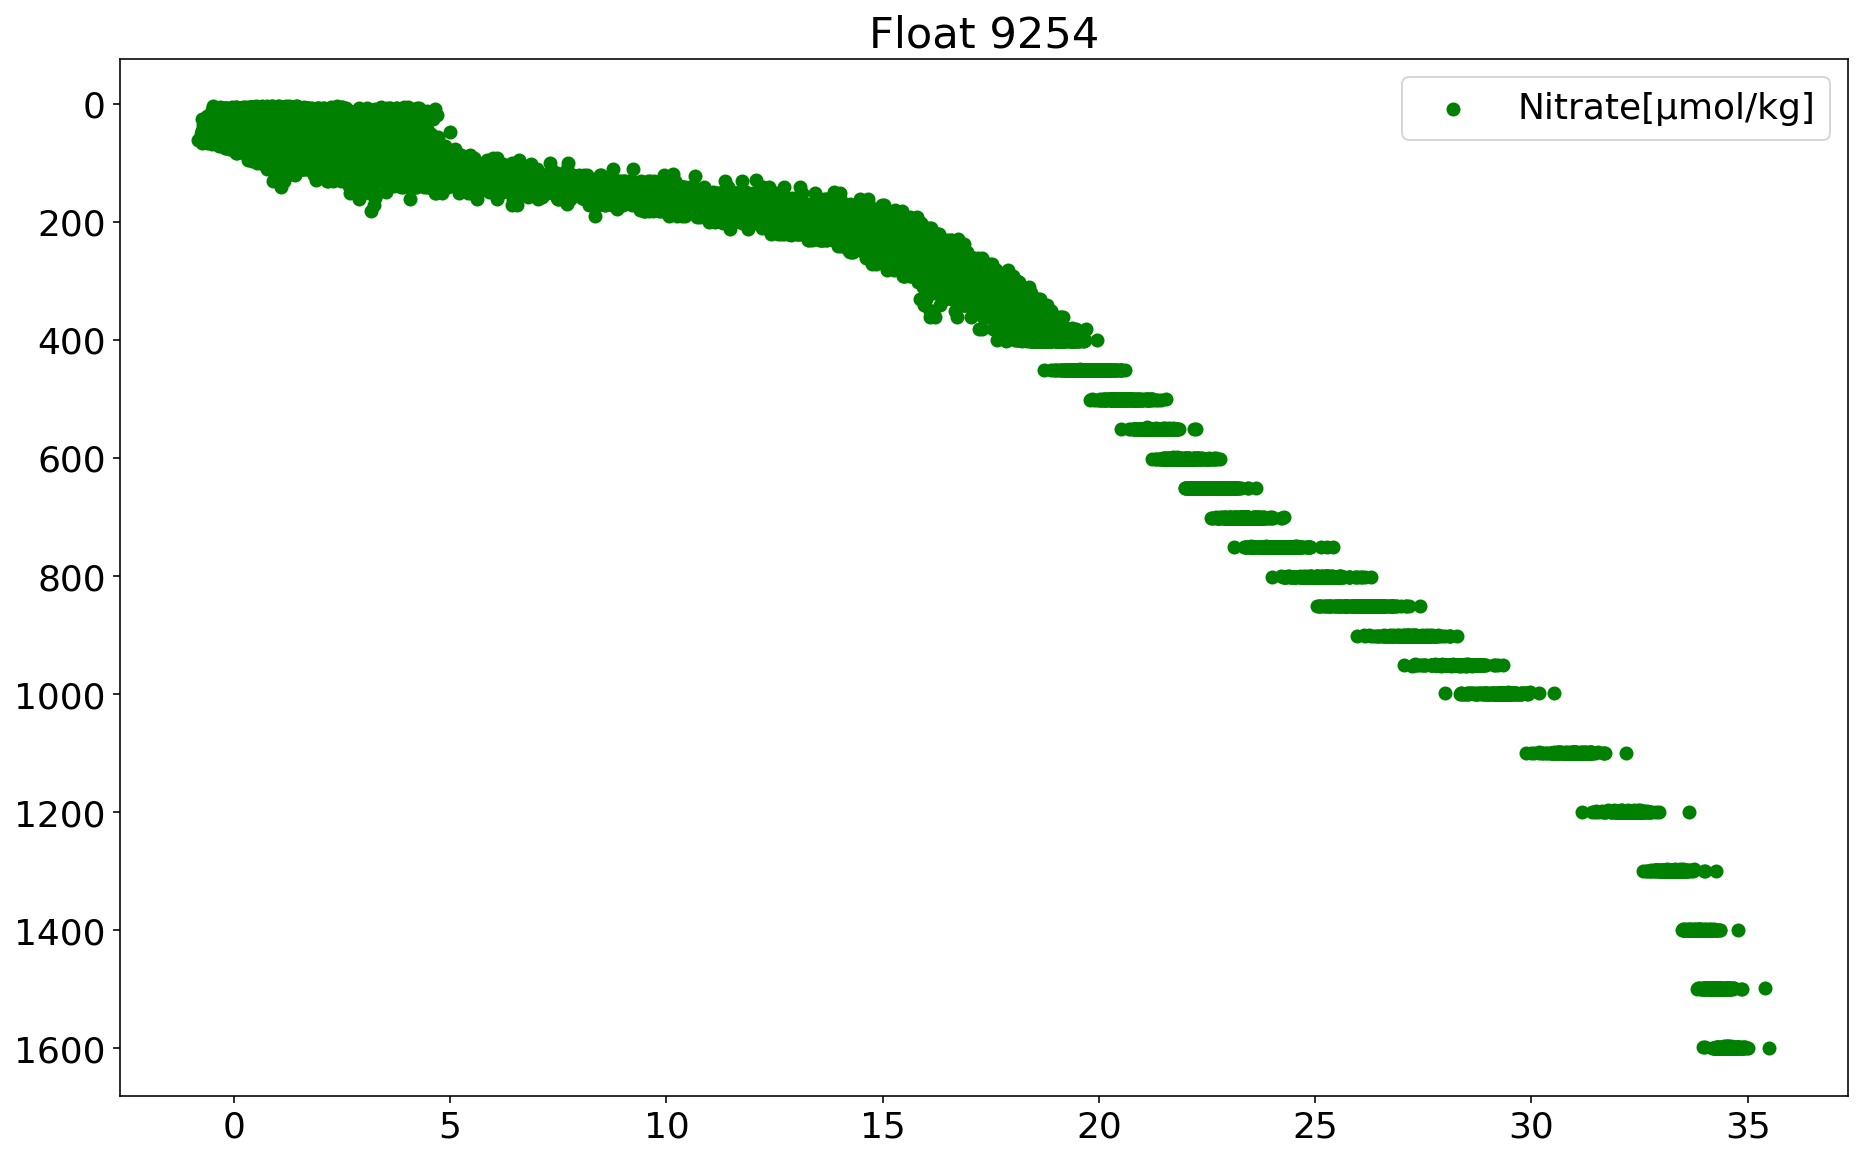

In [24]:
# is nitrate there?
var='Nitrate[µmol/kg]'
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='green')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'QC.png', dpi = 200)

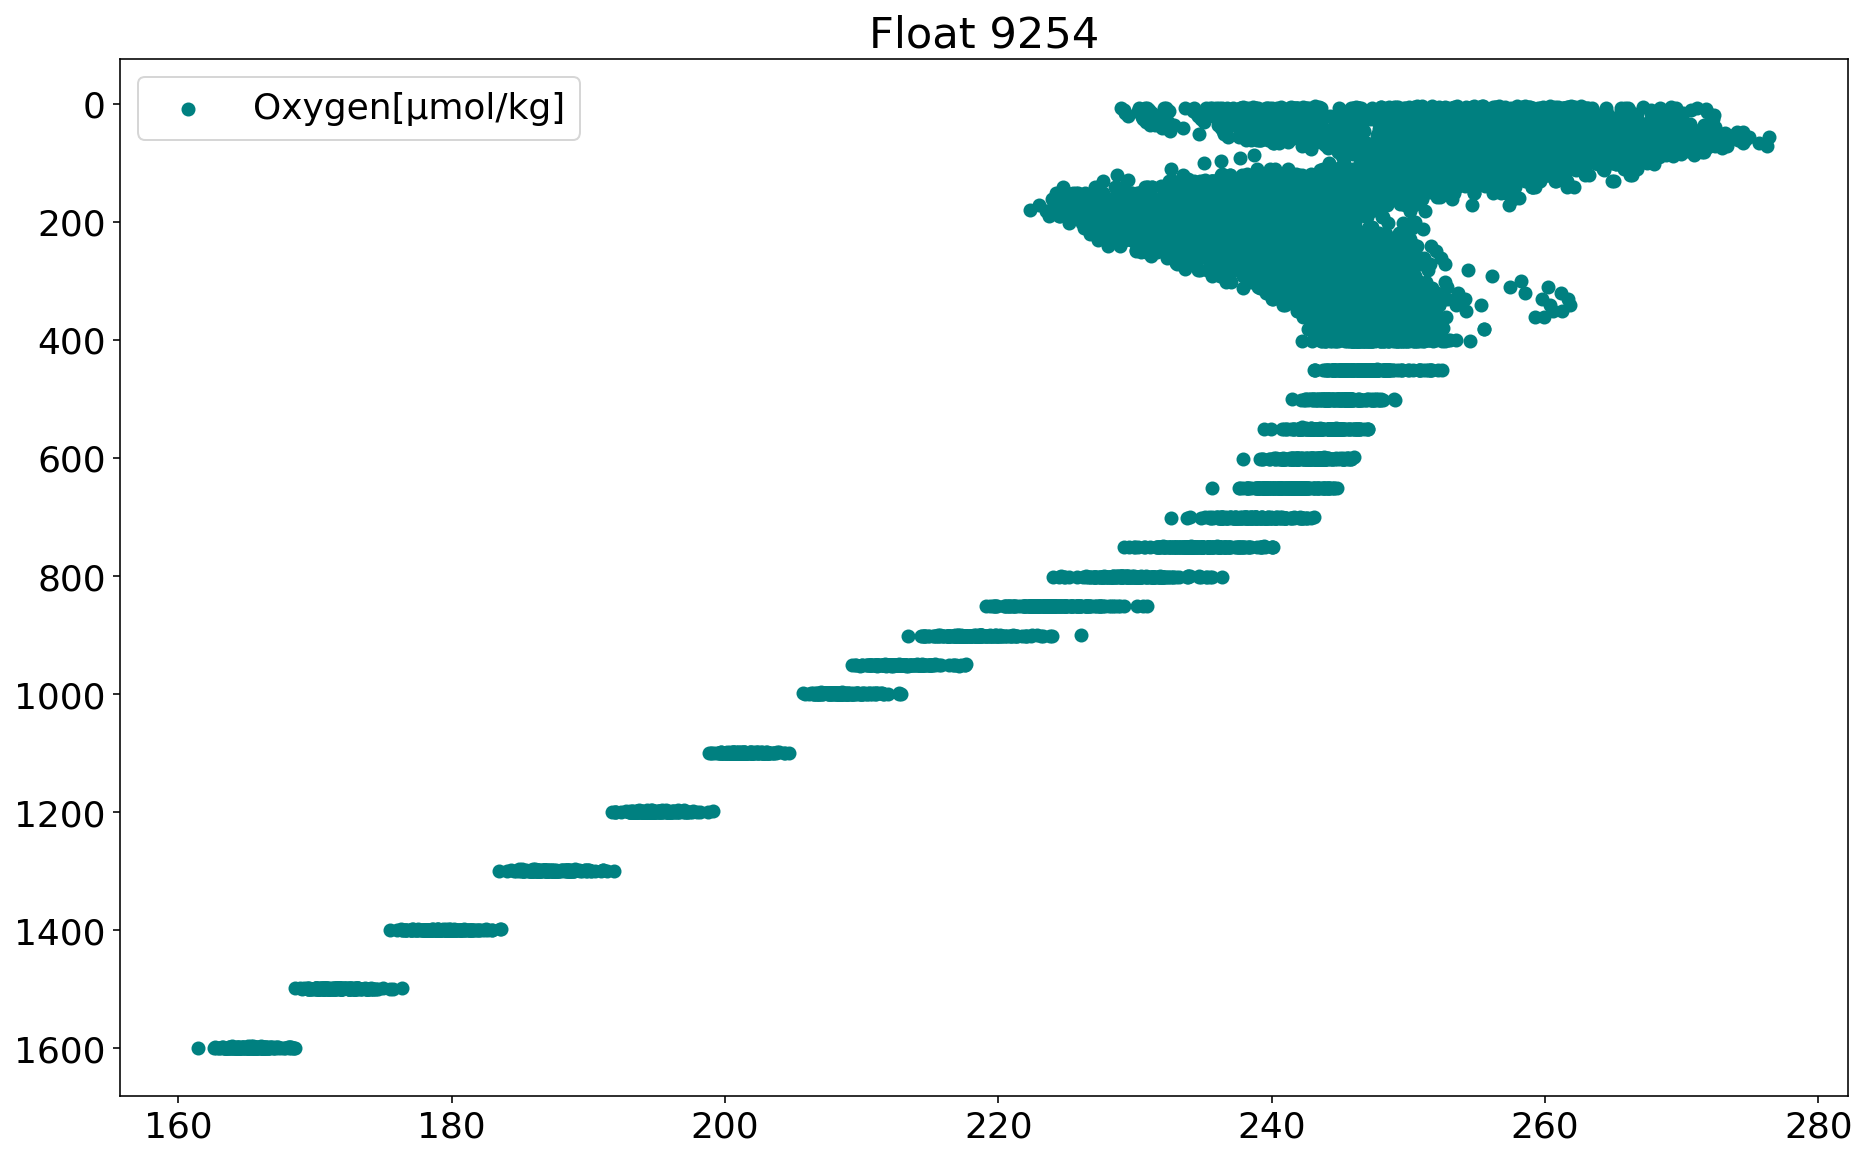

In [25]:
# is oxygen there?
var='Oxygen[µmol/kg]'
fig = plt.figure()
axes1= fig.add_axes([0.1, 0.1, .8, .8])
axes1.scatter(flt[var],flt['Pressure[dbar]'],label = var,color='teal')
axes1.legend()
axes1.set_title('Float '+floatnum)
axes1.invert_yaxis()
fig.savefig('F'+floatnum+var[0:3]+'QC.png', dpi = 200)

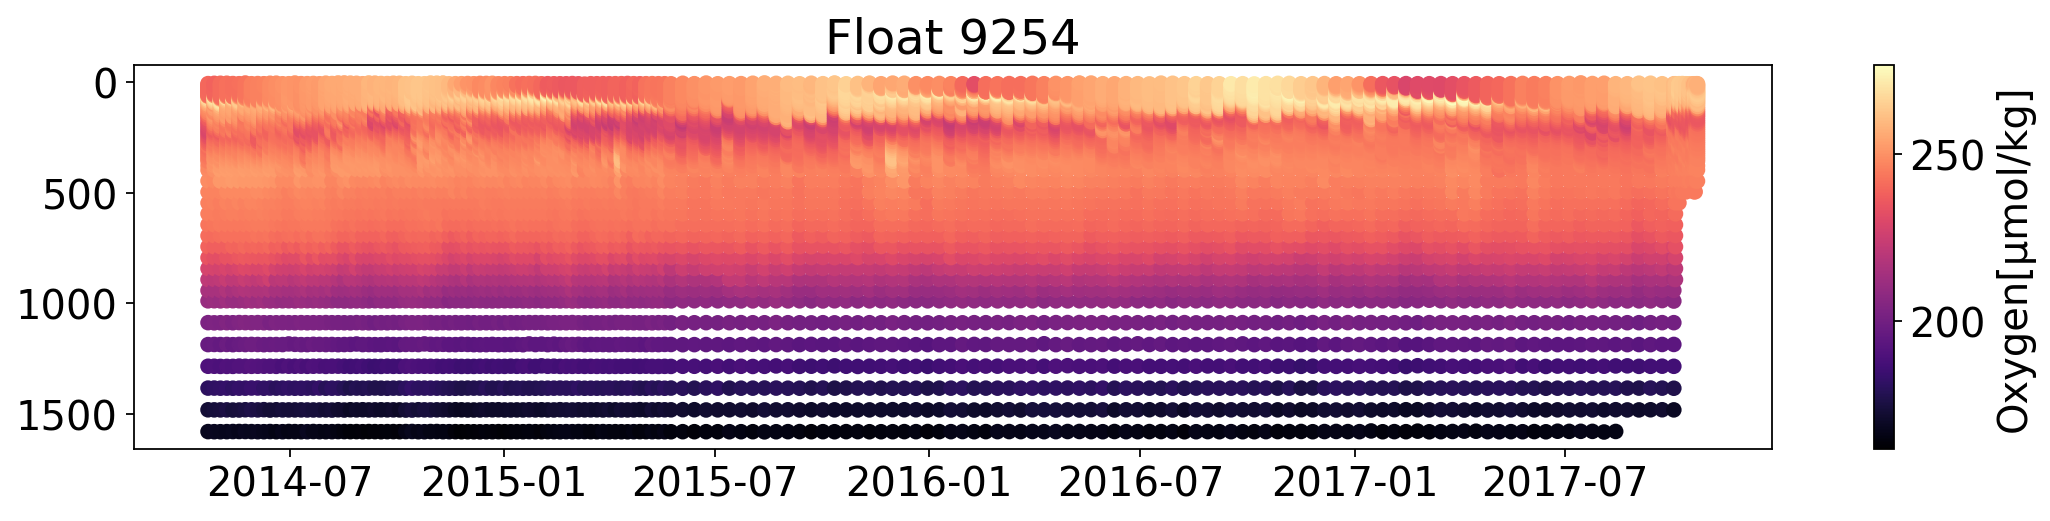

In [26]:
# Next look at oxygen over time
var='Oxygen[µmol/kg]'
fig = plt.figure(num=None, figsize=(16, 3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'magma',)
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
cb=plt.colorbar(sc)
cb.set_label(var)
fig.savefig('F'+floatnum+var[0:3]+'section.png', dpi = 200,bbox_inches='tight')

## Mixed Layer Depth
It would be helpful to know where the mixed layer is when we're thinking about surface ocean seasonality. Typically, mixed layer is calculated by looking at the density relative to the surface. As you move down the water column, the density increases and you can choose a threshold above which you are no longer in the mixed layer. This is typically 0.03 kg/m3 (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2004JC002378). First let's look at density. Sigma theta is actually the density minus 1000 kg/m3. The true density is closer to 1027 kg/m3.

In [27]:
flt['Sigma_theta[kg/m^3]']

0        27.514
1        27.464
2        27.409
3        27.333
4        27.266
          ...  
93652    25.823
93653    25.823
93654    25.823
93655    25.823
93656       NaN
Name: Sigma_theta[kg/m^3], Length: 93657, dtype: float64

In [28]:
# Start with station 1 as a test. Find the surface density (usually the minimum, but not always- fix later)
station=1
surfacedens=flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
surfacedens

25.102

In [29]:
# Find where in that station the density is greater than 0.03 greater than the surface density
# the shallowest of those depths is the mixed layer depth
MLD=flt['Depth[m]'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min()
MLD

62.44

In [30]:
# Calculate MLD for each station
MLD=[]
for station in flt['Station'].unique():
    surfacedens=flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
    MLD.append([station,flt['date'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
                flt['Depth[m]'].loc[(flt['Station']==station)&(flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
              flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
              flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at MLD. First column is the Station, second column is datenum, second column is the MLD
MLD = pd.DataFrame(data=MLD, columns=['Station', 'date', 'MLD','Lon [°E]','Lat [°N]'])
print(MLD)

     Station                date     MLD  Lon [°E]  Lat [°N]
0          1 2014-04-21 18:36:00  62.440   209.981   -39.698
1          2 2014-04-27 02:13:00  59.830   209.864   -39.783
2          3 2014-05-02 09:44:00  73.619   209.795   -39.843
3          4 2014-05-07 20:42:00  65.584   209.680   -39.889
4          5 2014-05-13 03:04:00  68.063   209.651   -39.952
..       ...                 ...     ...       ...       ...
167      168 2017-10-18 16:49:00   7.791   202.071   -37.939
168      169 2017-10-19 16:53:00  15.979   202.092   -37.953
169      170 2017-10-20 16:53:00  33.743   202.130   -37.996
170      171 2017-10-21 16:46:00  27.789   202.156   -37.995
171      172 2017-10-22 16:49:00  25.804   202.167   -37.992

[172 rows x 5 columns]


In [ ]:
# Density in the mixed layer
# First, set the depth to which you wish to plot and keep it the same for subsequent plots
depth=MLD['MLD'].max()+50 #plot to depth of mixed layer plus some number of m

var='Sigma_theta[kg/m^3]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'Reds')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig('F'+floatnum+var[0:3]+'section.png', dpi = 200,bbox_inches='tight')

## Mixed layer climatology
The Holte and Talley climatology for mixed layer depth is informed by Argo profiles and it lives at http://mixedlayer.ucsd.edu/. It would be interesting to see how the mixed layer we calculated/observed from the float compares to the climatological mixed layer depth at the float location. This code section is adapted from Ryan Abernathy's Intro to Physical Oceanography notebook at https://nbviewer.jupyter.org/github/rabernat/intro_to_physical_oceanography/blob/master/lectures/03_air_sea_exchange.ipynb.


In [ ]:
# Downloads the netcdf file directly from the web. 
# `!` tells you that this command is a unix shell command
! curl -o Argo_mixedlayers_monthlyclim_12112019.nc http://mixedlayer.ucsd.edu/data/Argo_mixedlayers_monthlyclim_12112019.nc

In [ ]:
# Using xarray to open the MLD dataset
MLDclim = xr.open_dataset('Argo_mixedlayers_monthlyclim_12112019.nc')
MLDclim

In [ ]:
# July
fig, ax = plt.subplots()
im = mld.mld_da_mean[:,:,6].plot.imshow(extent=[mld.lon[0], mld.lon[-1], mld.lat[-1], mld.lat[0]], yincrease=True)
im.set_clim([0,500])
ax.set_title('July Mean Mixed Layer Depth')
plt.close()
fig

In [ ]:
MLDclim['lat'] # this data is every one degree by one degree

In [ ]:
# Loop through the MLD climatology xarray and find the lat,lon,time closest to the float's profile
# ADD LATER
    
    

## Look at biogeochemical section plots

In [ ]:
# Next look at pCO2 over time
var='pCO2_LIAR[µatm]'
flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'Reds')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig('F'+floatnum+var[0:3]+'section.png', dpi = 200, bbox_inches='tight')

In [ ]:
# Next look at Nitrate over time
var='Nitrate[µmol/kg]'
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=flt[var],cmap = 'Purples')
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label(var)
# automatically adjusts the colorbar based on the range of values youre plotting
sc.set_clim(vmin = flt[var].loc[(flt['Depth[m]']<depth)].min(), 
            vmax = flt[var].loc[(flt['Depth[m]']<depth)].max()) 
fig.savefig('F'+floatnum+var[0:3]+'section.png', dpi = 200, bbox_inches='tight')

In [ ]:
# Next look at Chlorophyll over time 
var='Chl_a_corr[mg/m^3]'
fig = plt.figure(num=None, figsize=(16,3), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0.1, 0.1, .8, .8])
sc=ax.scatter(flt['date'],flt['Depth[m]'],c=np.log(flt[var]),cmap = 'Greens') #Log scale
ax.plot(MLD['date'],MLD['MLD'],c='magenta')
ax.invert_yaxis()
ax.set_title('Float '+floatnum)
ax.set_ylim([depth,0])
cb=plt.colorbar(sc)
cb.set_label('log('+var+')')
fig.savefig('F'+floatnum+var[0:3]+'section.png', dpi = 200, bbox_inches='tight')

## Make a time series plot of average top 30 m observations
Here we use the pandas groupby function to group the near-surface data by station.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [ ]:
fltSurf=flt.loc[(flt['Pressure[dbar]']<30)]
fltSurfByStn=fltSurf.groupby('Station').mean()
fltSurfByStn

In [ ]:
# Groupby doesn't work on datetime column so it was dropped. We need to make a datetime array to be used with plotting
fltdates=[]
for station in flt['Station'].unique():
    fltdates.append([flt['date'].loc[(flt['Station']==station)].min()])
len(fltdates)

In [ ]:
# Unfortunately, sometimes the fltdates is 1 row longer than the groupby file. 
# Not sure how/why this happened but for now, we will just assume that 
# there is an extra date somewhere and drop the final date.
if len(fltdates)>len(fltSurfByStn):
    fltdates.pop()
fltdates

In [ ]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 5, ncols = 1,figsize=(15,20))

var='Temperature[°C]'
axes[0].plot(fltdates,fltSurfByStn[var])
#axes[0].set_title(var)
axes[0].set_ylabel(var)
axes[0].set_xlim(fltdates[0],fltdates[-1])

var='Salinity[pss]'
axes[1].plot(fltdates,fltSurfByStn[var])
#axes[1].set_title(var)
axes[1].set_ylabel(var)
axes[1].set_xlim(fltdates[0],fltdates[-1])

var='Chl_a_corr[mg/m^3]'
axes[2].plot(fltdates,np.log(fltSurfByStn[var]))
#axes[2].set_title(var)
axes[2].set_ylabel('log('+var+')')
axes[2].set_xlim(fltdates[0],fltdates[-1])

var='OxygenSat[%]'
axes[3].plot(fltdates,fltSurfByStn[var])
#axes[3].set_title(var)
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0],fltdates[-1])

var='Nitrate[µmol/kg]'
axes[4].plot(fltdates,fltSurfByStn[var])
#axes[4].set_title(var)
axes[4].set_ylabel(var)
axes[4].set_xlim(fltdates[0],fltdates[-1])

axes[0].set_title('Float '+floatnum)
# This is the first figure we're saving. We have given it a name, a type, and a dpi or
# dots per inch which is resolution
fig.savefig('F'+floatnum+'TS.png', dpi = 200, bbox_inches='tight')

## Seawater Toolbox
The seawater toolbox contains many functions useful for oceanographic data analysis. To see a list of what's there type `help(seawater)`. Let's calculate the freezing point of seawater over the float's lifetime. You could also calculate the oxygen saturation concentration. 

In [ ]:
seawater.fp(fltSurfByStn['Salinity[pss]'],fltSurfByStn['Pressure[dbar]'])

## Other miscellaneous plotting tools
In the following section I will demonstrate a few other neat plotting tools from the Seaborn toolbox: https://seaborn.pydata.org/#. 

For *this* specific dataset, using Seaborn doesn't always give us something oceanographically meaningful, but I want you to know that they exist.

The first example is using distplot: https://seaborn.pydata.org/generated/seaborn.distplot.html?highlight=distplot#seaborn.distplot

In [ ]:
var='Temperature[°C]'
var='Salinity[pss]'

sns.distplot(fltSurfByStn['Temperature[°C]'],kde='false')

The next couple of examples uses a jointplot: https://seaborn.pydata.org/generated/seaborn.jointplot.html

In [ ]:
sns.jointplot(x='Temperature[°C]',y='Salinity[pss]',data=fltSurfByStn,kind='hist')

In [ ]:
sns.jointplot(x='Temperature[°C]',y='Salinity[pss]',data=fltSurfByStn,kind='reg')

The next example wants to plot an entire dataframe. Our flt dataframe is too big, so I'm making a smaller dataframe called fltsmall with just the variables we want to plot.

In [ ]:
fltSurfByStnsmall=fltSurfByStn[['Chl_a_corr[mg/m^3]','Nitrate[µmol/kg]','Oxygen[µmol/kg]','pCO2_LIAR[µatm]','Temperature[°C]','Depth[m]']].copy()

In [ ]:
fltSurfByStnsmall

In [ ]:
sns.pairplot(fltSurfByStnsmall)
# This will take some time. Notice the "*" that appears to the upper left while the cell runs
# If something is taking longer to run than you think it should, that's called "hanging" and
# It may be due to an error. You can quit that cell by going up to "Kernel" in the menu bar and 
# clicking "interrupt"

In [ ]:
# You can also use the following code to make a pivot table with a subsample of the larger dataframe 
# to be used with seaborn grid plots
# a=flt.pivot_table(index='Pressure[dbar]',columns='Station',values='Temperature[°C]')

## Regression plot
https://seaborn.pydata.org/generated/seaborn.lmplot.htmls

What is the relationship between TALK and S? Do you think that Alkalinity can be estimated from just salinity?

In [ ]:
sns.lmplot(x='Salinity[pss]',y='TALK_LIAR[µmol/kg]',data=fltSurfByStn)

How about dissolved inorganic carbon (DIC)?

In [ ]:
sns.lmplot(x='Salinity[pss]',y='DIC_LIAR[µmol/kg]',data=fltSurfByStn) #Seaborn linear model plot

In [ ]:
# What are these two different blobs? Plot a third variable as a color
fltSurfByStn.plot.scatter(x='Salinity[pss]',y='DIC_LIAR[µmol/kg]',c=fltSurfByStn['Temperature[°C]'],cmap='Purples')